In [4]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from validate import validate
from sklearn.metrics import *

In [5]:
data_path = '/p/home/jusers/rojascampos1/juwels/MyProjects/PROJECT_deepacf/deeprain/rojascampos1/precipitation_prediction/data/'
stations = ['muOsna', 'wernig', 'braunl', 'redlen']

In [9]:
## Load files
trn_x = []
trn_y = []
tst_x = []
tst_y = []
tst_t = []

for st in stations:

    trn_x.append(np.loadtxt(data_path + st + '_0_4_5x5_allFeatures_created_2020-10-23/train_x.csv', delimiter=','))
    trn_y.append(np.loadtxt(data_path + st + '_0_4_5x5_allFeatures_created_2020-10-23/train_y.csv', delimiter=','))
    tst_x.append(np.loadtxt(data_path + st + '_0_4_5x5_allFeatures_created_2020-10-23/test_x.csv', delimiter=','))
    tst_y.append(np.loadtxt(data_path + st + '_0_4_5x5_allFeatures_created_2020-10-23/test_y.csv', delimiter=','))
    tst_t.append(np.load(data_path + st + '_0_4_5x5_allFeatures_created_2020-10-23/timepoints_test.npy'))

trn_x = np.concatenate(trn_x)
trn_y = np.concatenate(trn_y)

## Regression model    
trn_y = np.exp(trn_y) ### revert log transform 

batch_size = 32
epochs = 64

optimizer = tf.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredLogarithmicError()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)    


### Cross - validation
cvalid_mses = []
cvalid_models = []
cvalid_hist = []

kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(trn_x, trn_y):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(trn_x.shape[1])))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer, loss)
    hist = model.fit(trn_x[train_index], trn_y[train_index], batch_size, epochs, validation_data=(trn_x[test_index], trn_y[test_index]), callbacks=[early_stop], shuffle=True)

    pred = model(trn_x[test_index])
    pred = np.squeeze(pred)

    mse_cv = mean_squared_error(pred, trn_y[test_index])

    cvalid_models.append(model)
    cvalid_mses.append(mse_cv)
    cvalid_hist.append(hist)

index_best = np.argmin(cvalid_mses)
best_model = cvalid_models[index_best]
history = cvalid_hist[index_best]

best_model.summary()

Epoch 1/64
108/108 [==============================] - 9s 86ms/step - loss: 0.1760 - val_loss: 0.1371
Epoch 2/64
108/108 [==============================] - 8s 75ms/step - loss: 0.1275 - val_loss: 0.1264
Epoch 3/64
108/108 [==============================] - 7s 68ms/step - loss: 0.1149 - val_loss: 0.1196
Epoch 4/64
108/108 [==============================] - 8s 76ms/step - loss: 0.1050 - val_loss: 0.1156
Epoch 5/64
108/108 [==============================] - 8s 72ms/step - loss: 0.1012 - val_loss: 0.1081
Epoch 6/64
108/108 [==============================] - 8s 75ms/step - loss: 0.0959 - val_loss: 0.1094
Epoch 7/64
108/108 [==============================] - 8s 74ms/step - loss: 0.0920 - val_loss: 0.1092
Epoch 8/64
108/108 [==============================] - 8s 70ms/step - loss: 0.0906 - val_loss: 0.1114
Epoch 9/64
108/108 [==============================] - 7s 65ms/step - loss: 0.0867 - val_loss: 0.1165
Epoch 10/64
108/108 [==============================] - 7s 66ms/step - loss: 0.0839 - val_lo

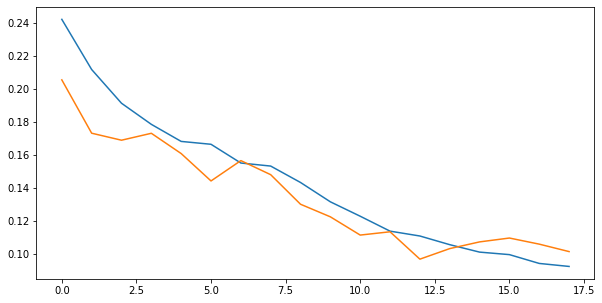

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
fig.show()

In [11]:
for idx, sta in enumerate(stations):

    pred = np.squeeze(best_model(tst_x[idx]))
    true_y = np.exp(tst_y[idx])


    leps  = validate(pred, tst_t[idx], [0], [4], False, sta)['LEPS']
    leps_cosmo = validate([], tst_t[idx], [0], [4], True, sta)['LEPS'][9]

    skill = 1 - (leps / leps_cosmo)
    print(sta, skill)

muOsna 0.1913866716168554
wernig 0.33538385826771655
braunl 0.0604087538433713
redlen 0.2616371120962635


In [ ]:
Median skill_muOsna = 0.34611100798217936
Median skill_wernig = 0.280265748031496
Median skill_braun = 0.2096219931271478
Median skill_redlen = 0.44185402153261555